In [3]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import HTML
from tqdm import tqdm
from scipy.ndimage import convolve
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['animation.embed_limit'] = 1024

In [4]:
colors = [(0, 0, 0), (1, 0, 0), (1, 1, 0)]
cmap = LinearSegmentedColormap.from_list("custom_colormap", colors, N=256)

In [5]:
Nx, Ny = 128, 128
dx = dy = 1
dt = 0.01
gamma = np.sqrt(3)
total_steps = 50000

In [6]:
def initial_condition(Nx, Ny):
    np.random.seed(42)
    return np.clip(np.random.uniform(-1, 1, (Nx, Ny)), -1, 1)


def train_data(gamma, dx, dy, dt, T, u0):
    state = u0
    kernel = np.array([[0, 1, 0],[1, -4, 1],[0, 1, 0]]) / (dx * dy)
    train, time_points = [], []
    print("Training starting:")
    for step in tqdm(range(T)):
        mu = state**3 - state - gamma**2 * convolve(state, kernel, mode='wrap')
        mobility = np.clip(1 - state**2, 0, 1)
        state += dt * convolve(mobility * mu, kernel, mode='wrap')
        if step % 30 == 0:
            train.append(state.copy())
            time_points.append(step * dt)
    print("Model refinement 25 Batch-size starting")
    return np.array(train), np.array(time_points)


u0 = initial_condition(Nx,Ny)
frames, times = train_data(gamma, dx, dy, dt, total_steps, u0)


frames_tensor = torch.tensor(frames, dtype=torch.float32)
times_tensor = torch.tensor(times, dtype=torch.float32)

dataset = TensorDataset(frames_tensor[:-1], frames_tensor[1:])
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class FP_PINN(nn.Module):
    def __init__(self):
        super(FP_PINN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x


model = FP_PINN().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 25
losses = []
predictions = []
for epoch in tqdm(range(num_epochs)):
    epoch_loss = 0
    for u_t, u_t1 in dataloader:
        u_t, u_t1 = u_t.unsqueeze(1).to(device), u_t1.unsqueeze(1).to(device)
        optimizer.zero_grad()
        u_pred = model(u_t)
        predictions.append(u_pred)
        loss = criterion(u_pred, u_t1)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(dataloader))


Training starting:


100%|██████████| 50000/50000 [01:37<00:00, 511.36it/s]


Model refinement 25 Batch-size starting


100%|██████████| 25/25 [37:24<00:00, 89.79s/it] 


In [ ]:
np.save("-pinns_canh_hilliard.npy", frames)

In [ ]:
plt.plot(losses)
plt.title("Courbe de perte")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

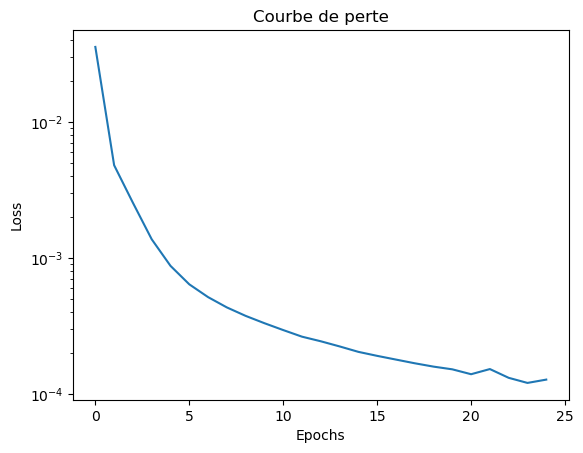

In [20]:
plt.semilogy(losses)
plt.title("Courbe de perte")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [ ]:
fig, ax = plt.subplots()
frames[0] = initial_condition(Nx, Ny)
im = ax.imshow(initial_condition(Nx, Ny), cmap=cmap, extent=(-0.5, 0.5, 0, 1), vmin=-1, vmax=1)
plt.colorbar(im)

time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, color="white")


def animate(i):
    with torch.no_grad():
        u_pred = model(frames_tensor[i].unsqueeze(0).unsqueeze(0).to(device))
    im.set_array(u_pred.squeeze().cpu().numpy())
    time_text.set_text(f'Temps: {times[i]/100:.3f} s')
    return [im, time_text]


anim = FuncAnimation(fig, animate, frames=len(frames), interval=50, blit=True)
plt.close()
HTML(anim.to_jshtml())

In [ ]:
# plt.imshow(predictions[0].squeeze(0).detach().numpy(), cmap=cmap, extent=(-0.5, 0.5, 0, 1), vmin=-1, vmax=1)